In [27]:
# 📓 Notebook : Classification multimodale du cancer du sein avec CNN + Transformer

# 📦 Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import json
from glob import glob
from PIL import Image
from collections import Counter


In [28]:

# 📁 Dossiers
image_dir_le = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM'
image_dir_sub = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM'
json_dir = 'CDD-CESM/json_output'
excel_path = 'processed_metadata.csv'


In [29]:

# 🔄 Chargement des images (8 vues par patient)
def load_image_stack(patient_id):
    paths = [
        f"{image_dir_le}/P{patient_id}_L_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_L_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_MLO.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_MLO.jpg",
    ]
    imgs = [np.array(Image.open(p).convert('L').resize((224, 224))) for p in paths]
    stack = np.stack(imgs, axis=-1)
    return stack / 255.0


In [30]:

# 🔢 Chargement des métadonnées
meta_df = pd.read_csv(excel_path)
meta_df = meta_df.dropna(subset=['Patient_ID', 'Pathology Classification/ Follow up'])
meta_df['Patient_ID'] = meta_df['Patient_ID'].astype(str)


In [31]:

# --- Textes JSON
texts = []
for pid in meta_df['Patient_ID']:
    path = os.path.join(json_dir, f"P{pid}.json")
    if os.path.exists(path):
        with open(path, encoding="utf-8") as f:
            try:
                d = json.load(f)
                flat_text = []
                for v in d.values():
                    flat_text.extend(map(str, v) if isinstance(v, list) else [str(v)])
                texts.append(" ".join(flat_text))
            except:
                texts.append("")
    else:
        texts.append("")


In [32]:

# --- Echantillonnage 80%
sampled_df = meta_df.sample(frac=0.8, random_state=42)
sampled_patient_ids = sampled_df['Patient_ID'].tolist()


In [33]:

# --- Images valides
images = []
valid_labels = []
valid_pids = []
skipped_image = 0

for pid, label in zip(sampled_df['Patient_ID'], sampled_df['Pathology Classification/ Follow up']):
    try:
        img = load_image_stack(pid)
        images.append(img)
        valid_labels.append(label)
        valid_pids.append(pid)
    except:
        skipped_image += 1
        continue


In [34]:

# --- Alignement des données
image_patient_ids = set(valid_pids)
text_patient_ids = set(sampled_patient_ids)
metadata_patient_ids = set(meta_df['Patient_ID'])
common_patient_ids = list(image_patient_ids & text_patient_ids & metadata_patient_ids)

image_dict = {pid: img for pid, img in zip(valid_pids, images) if pid in common_patient_ids}
label_dict = {pid: label for pid, label in zip(valid_pids, valid_labels) if pid in common_patient_ids}
text_dict = {pid: text for pid, text in zip(sampled_patient_ids, texts) if pid in common_patient_ids}
meta_dict = {pid: meta_df[meta_df['Patient_ID'] == pid].iloc[0] for pid in common_patient_ids}

images_filtered = np.array([image_dict[pid] for pid in common_patient_ids])
labels_filtered = [label_dict[pid] for pid in common_patient_ids]
texts_filtered = [text_dict[pid] for pid in common_patient_ids]
meta_df_filtered = pd.DataFrame([meta_dict[pid] for pid in common_patient_ids])


In [35]:

# --- Textes vectorisés
vectorizer = TfidfVectorizer(max_features=1000)
text_features_filtered = vectorizer.fit_transform(texts_filtered).toarray()

# --- Encodage des métadonnées
numerical = meta_df_filtered.select_dtypes(include=['float', 'int']).columns.tolist()
categorical = meta_df_filtered.select_dtypes(include=['object']).drop(columns=['Patient_ID', 'Pathology Classification/ Follow up']).columns.tolist()

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

meta_num_filtered = scaler.fit_transform(meta_df_filtered[numerical])
meta_cat_filtered = encoder.fit_transform(meta_df_filtered[categorical])
meta_features_filtered = np.concatenate([meta_num_filtered, meta_cat_filtered], axis=1)

# --- Encodage des labels
valid_labels_encoded, label_names = pd.factorize(labels_filtered)
labels_cat = to_categorical(valid_labels_encoded)

# --- Poids de classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(valid_labels_encoded), y=valid_labels_encoded)
class_weight_dict = dict(enumerate(class_weights))


/tmp/ipykernel_29726/1443076994.py:17: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  valid_labels_encoded, label_names = pd.factorize(labels_filtered)


In [36]:

# --- Split train/test
X_img_temp, X_img_test, X_meta_temp, X_meta_test, X_txt_temp, X_txt_test, y_temp, y_test = train_test_split(
    images_filtered, meta_features_filtered, text_features_filtered, labels_cat,
    test_size=0.1, random_state=42)

X_img_train, X_img_val, X_meta_train, X_meta_val, X_txt_train, X_txt_val, y_train, y_val = train_test_split(
    X_img_temp, X_meta_temp, X_txt_temp, y_temp,
    test_size=0.2, random_state=42)


In [37]:

# 🔧 Transformer block
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Layer

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [38]:

# 🧠 Modèle multimodal CNN + Transformer
img_input = Input(shape=(224, 224, 8))
meta_input = Input(shape=(meta_features_filtered.shape[1],))
text_input = Input(shape=(text_features_filtered.shape[1],))

# CNN images
x_img = Conv2D(32, (3, 3), activation='relu')(img_input)
x_img = MaxPooling2D()(x_img)
x_img = Conv2D(64, (3, 3), activation='relu')(x_img)
x_img = GlobalAveragePooling2D()(x_img)
x_img = Dense(64, activation='relu')(x_img)

# MLP metadata + texte
x_meta = Dense(64, activation='relu')(meta_input)
x_text = Dense(64, activation='relu')(text_input)


In [39]:
from keras.layers import Lambda, Concatenate, GlobalAveragePooling1D, Dense
from keras.models import Model

# Ajouter une dimension temporelle à chaque modalité
x_img_seq = Lambda(lambda x: tf.expand_dims(x, axis=1))(x_img)
x_meta_seq = Lambda(lambda x: tf.expand_dims(x, axis=1))(x_meta)
x_text_seq = Lambda(lambda x: tf.expand_dims(x, axis=1))(x_text)

# Fusion multimodale : (batch, 3, 64)
fused = Concatenate(axis=1)([x_img_seq, x_meta_seq, x_text_seq])

# Transformer
fused = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(fused)

# Agrégation temporelle
fused = GlobalAveragePooling1D()(fused)

# Classification finale
x = Dense(128, activation='relu')(fused)
output = Dense(len(label_names), activation='softmax')(x)

# Modèle
model = Model(inputs=[img_input, meta_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │      2,336 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 381)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 272)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │     24,448 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     17,472 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 1, 64)     │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1, 64)     │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 1, 64)     │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3, 64)     │          0 │ lambda_6[0][0],   │
│ (Concatenate)       │                   │            │ lambda_7[0][0],   │
│                     │                   │            │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_2 │ (None, 3, 64)     │     83,200 │ concatenate_2[0]… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 3)         │        387 │ dense_17[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 158,819 (620.39 KB)

 Trainable params: 158,819 (620.39 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:

# 🚂 Entraînement
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [X_img_train, X_meta_train, X_txt_train], y_train,
    validation_data=([X_img_val, X_meta_val, X_txt_val], y_val),
    epochs=10,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step - accuracy: 0.3054 - loss: 1.1476 - val_accuracy: 0.3429 - val_loss: 1.0863
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.5758 - loss: 0.9218 - val_accuracy: 0.4571 - val_loss: 1.0988
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.7010 - loss: 0.7966 - val_accuracy: 0.2571 - val_loss: 1.3086
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.7108 - loss: 0.7085 - val_accuracy: 0.3714 - val_loss: 1.3962
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.7441 - loss: 0.6358 - val_accuracy: 0.2286 - val_loss: 1.7408
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.8488 - loss: 0.4626 - val_accuracy: 0.3714 - val_loss: 1.7377


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
              precision    recall  f1-score   support

   Malignant       0.42      0.83      0.56         6
      Normal       0.25      0.17      0.20         6
      Benign       0.50      0.25      0.33         8

    accuracy                           0.40        20
   macro avg       0.39      0.42      0.36        20
weighted avg       0.40      0.40      0.36        20

F1-score (weighted): 0.36
Accuracy: 0.4


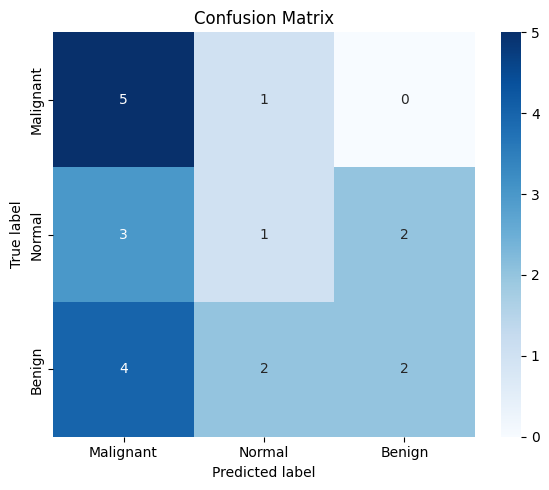

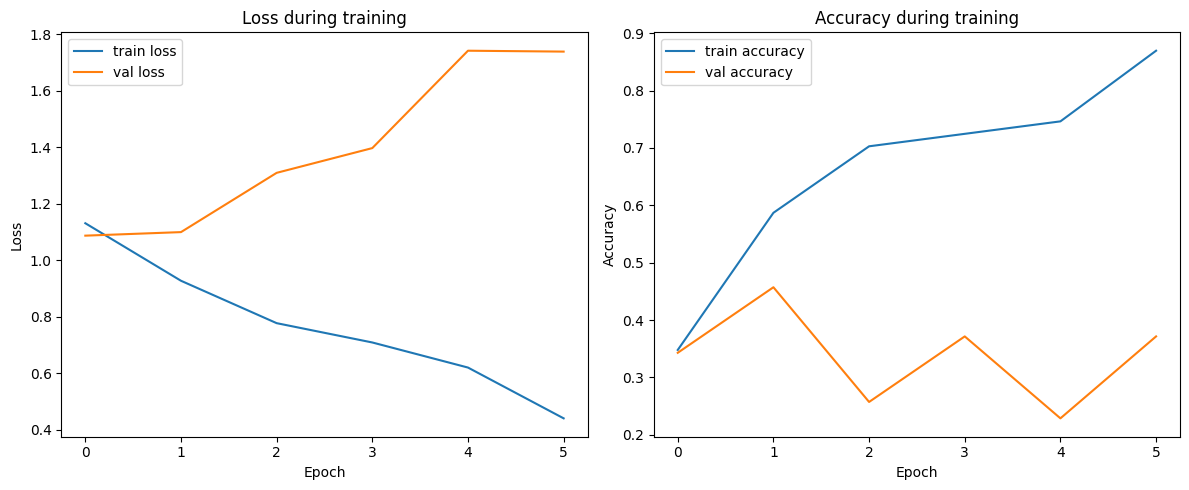

In [41]:
# 📊 Evaluation test
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions
y_pred_proba = model.predict([X_img_test, X_meta_test, X_txt_test])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Rapport de classification
print(classification_report(y_true, y_pred, target_names=label_names))
print("F1-score (weighted):", f1_score(y_true, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_true, y_pred))

# 📌 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 📈 Courbes de loss et accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Appelle la fonction avec l'objet history renvoyé par model.fit()
plot_training_history(history)


In [42]:

# AUC
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_true, classes=range(len(label_names)))
y_pred_bin = y_pred_proba
auc_score = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')
print("ROC AUC (macro, one-vs-rest):", auc_score)


ROC AUC (macro, one-vs-rest): 0.5694444444444443
